# Processing titanic dataset

In [3]:
import pandas as pd
import numpy as np
import os

In [4]:
main_path=os.path.join(os.path.pardir,'data','raw')
train_path=os.path.join(main_path,'train.csv')
test_path=os.path.join(main_path,'test.csv')

In [5]:
train_df=pd.read_csv(train_path,index_col='PassengerId')
test_df=pd.read_csv(test_path,index_col='PassengerId')

In [7]:
#here i concatinate both test and training df
#but first since test data doesn't have survived column ,so add it with a default value(here its -800)
test_df['Survived']=-800
df=pd.concat((train_df,test_df),axis=0)


/home/ayushman/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:4: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  after removing the cwd from sys.path.


In [8]:
#use iloc for position based indexing
df.iloc[1:10,2:7]

,Embarked,Fare,Name,Parch,Pclass
PassengerId,,,,,
2,C,71.2833,"Cumings, Mrs. John Bradley (Florence Briggs Th...",0,1
3,S,7.9250,"Heikkinen, Miss. Laina",0,3
4,S,53.1000,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",0,1
5,S,8.0500,"Allen, Mr. William Henry",0,3
6,Q,8.4583,"Moran, Mr. James",0,3
7,S,51.8625,"McCarthy, Mr. Timothy J",0,1
8,S,21.0750,"Palsson, Master. Gosta Leonard",1,3
9,S,11.1333,"Johnson, Mrs. Oscar W (Elisabeth Vilhelmina Berg)",2,3
10,C,30.0708,"Nasser, Mrs. Nicholas (Adele Achem)",0,2


In [9]:
#logic based indexing , can be combined with & and | for complex logic
male_pass_firstclass=df.loc[((df.Sex=='male')&(df.Pclass==1)),:]
print(len(male_pass_firstclass))

179


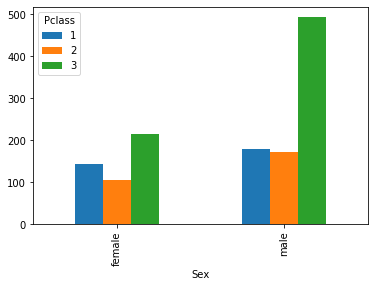

In [13]:
pd.crosstab(df.Sex,df.Pclass).plot(kind='bar')

In [11]:
%matplotlib inline

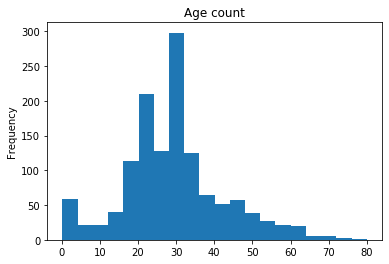

In [28]:
df.Age.plot(kind='hist',title='Age count',rot=0,bins=20);

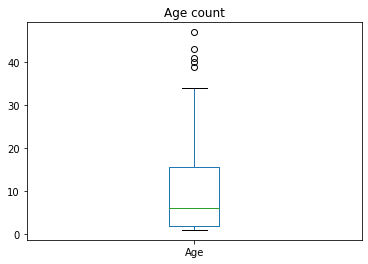

In [14]:
df.Age.value_counts().plot(kind='box',title='Age count',rot=0);

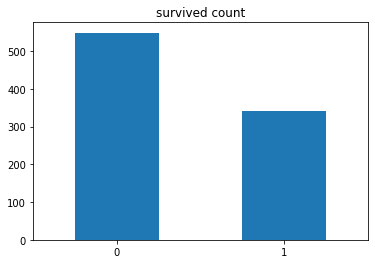

In [15]:
df[df.Survived!=-800].Survived.value_counts().plot(kind='bar',title='survived count',rot=0);

### filling missing data

In [16]:
#missing embarked values
df[df.Embarked.isnull()]

,Age,Cabin,Embarked,Fare,Name,Parch,Pclass,Sex,SibSp,Survived,Ticket
PassengerId,,,,,,,,,,,
62,38.0,B28,NaN,80.0,"Icard, Miss. Amelie",0,1,female,0,1,113572
830,62.0,B28,NaN,80.0,"Stone, Mrs. George Nelson (Martha Evelyn)",0,1,female,0,1,113572


In [17]:
#replace missing embarked value with 'C' , we have made inplace true so that python doesn't make copy of df
df.Embarked.fillna('C',inplace=True)

In [18]:
#filling missing fare data with median of 3rd class and Embarked at 'S'
med_fare=df.loc[(df.Pclass==3)&(df.Embarked=='S'),'Fare'].median()
df.Fare.fillna(med_fare,inplace=True)

In [19]:
#so here started working on filling up missing Age values and here median of Title name of people is used as 
#variations in age
# Function to extract the title from the name 
def GetTitle(name):
    title_group = {'mr' : 'Mr', 
               'mrs' : 'Mrs', 
               'miss' : 'Miss', 
               'master' : 'Master',
               'don' : 'Sir',
               'rev' : 'Sir',
               'dr' : 'Officer',
               'mme' : 'Mrs',
               'ms' : 'Mrs',
               'major' : 'Officer',
               'lady' : 'Lady',
               'sir' : 'Sir',
               'mlle' : 'Miss',
               'col' : 'Officer',
               'capt' : 'Officer',
               'the countess' : 'Lady',
               'jonkheer' : 'Sir',
               'dona' : 'Lady'
                 }
    first_name_with_title = name.split(',')[1]
    title = first_name_with_title.split('.')[0]
    title = title.strip().lower()
    return title_group[title]


In [20]:
# create Title feature
df['Title'] =  df.Name.map(lambda x : GetTitle(x))

In [22]:
# replace missing values
title_age_median = df.groupby('Title').Age.transform('median')
df.Age.fillna(title_age_median , inplace=True)

### outliers in fare

In [29]:
# binning
pd.qcut(df.Fare, 4)
pd.qcut(df.Fare, 4, labels=['very_low','low','high','very_high']) # discretization
# create fare bin feature
df['Fare_Bin'] = pd.qcut(df.Fare, 4, labels=['very_low','low','high','very_high'])

### feature engineering

In [32]:
# creating age state column
df['AgeState']=np.where(df['Age']>=18,'adult','child') #if the condition of np.where is correct adult is written
#otherwise child

In [34]:
# Family : Adding Parents with Siblings
df['FamilySize'] = df.Parch + df.SibSp + 1 # 1 for self

In [40]:
#adding column for checking if a person is mother or not
# a lady aged more thana 18 who has Parch >0 and is married (not Miss)
df['IsMother'] = np.where(((df.Sex == 'female') & (df.Parch > 0) & (df.Age > 18) & (df.Title != 'Miss')), 1, 0)

In [41]:
#adding the deck feature
# set the value to NaN
df.loc[df.Cabin == 'T', 'Cabin'] = np.NaN
# extract first character of Cabin string to the deck
def get_deck(cabin):
    return np.where(pd.notnull(cabin),str(cabin)[0].upper(),'Z')
df['Deck'] = df['Cabin'].map(lambda x : get_deck(x))

### categorial encoding

In [44]:
#encoding the male/female to 1/0
df['IsMale']=np.where(df.Sex=='male',1,0)

In [45]:
#using one-hot encoding for columns deck,Pclass,title,Agestate
df = pd.get_dummies(df,columns=['Deck', 'Pclass','Title', 'Fare_Bin', 'Embarked','AgeState'])
#here get_dummies meathod performs automatic encoding for mentioned columns ,it also performs seperate encoding
#for agestate since it can be considered binary encoding also

### cleaning and saving the data frame

In [47]:
#since we have encoded the alphabetical categories to numerical one , we don't need it anymore
df.drop(['Cabin','Name','Ticket','Parch','SibSp','Sex'],axis=1,inplace=True)

In [48]:
#here since Survived is the target column , its preffered to put it in end
columns = [column for column in df.columns if column != 'Survived'] #grouping the parts of dataframe 
#without survived column (that is taking all columns except Survived)
columns = ['Survived'] + columns #adding survived column at the end
df = df[columns]#assigning new dataframe to original dataframe 

In [50]:
#saving the new processed dataframe in data/processed as separate train.csv and test.csv
processed_data_path = os.path.join(os.path.pardir,'data','processed')
write_train_path = os.path.join(processed_data_path, 'train.csv')#variable to store train
write_test_path = os.path.join(processed_data_path, 'test.csv')#variable to store test
## separating the new df to train and test and saving it
# train data
df.loc[df.Survived != -800].to_csv(write_train_path) #since we made survived of test to -800
# test data
columns = [column for column in df.columns if column != 'Survived']
df.loc[df.Survived == -800, columns].to_csv(write_test_path)#saving the grouped parts of dataframe
#(all except 'Survived' column) having survived column=-800

processing_data.ipynb
